- Brad Howlett (bth2g)  
- Eric Larson (rel4yx)  
- Hanim Song (hs4cf) 

# What is in here:
- Exploratory data analysis
- Data splitting/sampling
- Model construction with at least 3 models
- Model evaluation

## Combining Features and Building Predictive Models

In [2]:
## this is for my (Eric) Spark setup, you don't need to run this
#import findspark
#findspark.init()

In [32]:
import os
from pyspark.sql import SparkSession
import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from functools import reduce
from pyspark.sql.functions import col, asc
from pyspark.sql import SQLContext
from pyspark.sql.types import StructType
from pyspark.sql.types import StructField
from pyspark.sql.types import StringType, DoubleType, DateType
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

import pyspark.mllib.regression as reg
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.tree import RandomForest, RandomForestModel, GradientBoostedTrees, GradientBoostedTreesModel

from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, RandomForestClassificationModel, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler
import plotly.graph_objects as go


In [33]:
spark = SparkSession \
    .builder \
    .getOrCreate()

sc = spark.sparkContext

## Import Candidates

In [34]:
df_house = spark.read.csv('df_house.csv', inferSchema=True, header=True)

In [35]:
#clean up some titles
df_house = df_house.withColumnRenamed('candidatevotes', 'CAND_VOTES')
df_house = df_house.withColumnRenamed('totalvotes', 'TOTAL_VOTES')
df_house = df_house.withColumnRenamed('VOTE_percent', 'PERCENT_VOTES')

#drop index that is brought in
df_house = df_house.drop(col('_c0'))

In [36]:
df_house.printSchema()

root
 |-- CAND_ID: string (nullable = true)
 |-- CAND_NAME: string (nullable = true)
 |-- CAND_PTY_AFFILIATION: string (nullable = true)
 |-- CAND_ELECTION_YR: integer (nullable = true)
 |-- CAND_OFFICE_ST: string (nullable = true)
 |-- CAND_OFFICE: string (nullable = true)
 |-- CAND_OFFICE_DISTRICT: double (nullable = true)
 |-- CAND_ICI: string (nullable = true)
 |-- CAND_STATUS: string (nullable = true)
 |-- CAND_PCC: string (nullable = true)
 |-- CAND_CITY: string (nullable = true)
 |-- CAND_ST: string (nullable = true)
 |-- CAND_ZIP: double (nullable = true)
 |-- CAND_VOTES: integer (nullable = true)
 |-- TOTAL_VOTES: integer (nullable = true)
 |-- PERCENT_VOTES: double (nullable = true)
 |-- WINNER: integer (nullable = true)



### Add Incumbent feature column as 1/0

In [37]:
df_house.groupBy('CAND_ICI').count().show()

+--------+-----+
|CAND_ICI|count|
+--------+-----+
|    null|    5|
|       O|  198|
|       C|  655|
|       I|  692|
+--------+-----+



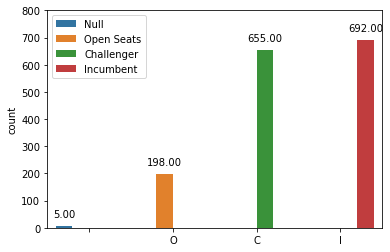

In [38]:
# Sort CAND_ICI
fig,ax = plt.subplots()
fig.set_size_inches(14,81)
df_house_count = df_house.groupBy('CAND_ICI').count()
df_house_count_pd = df_house_count.select('*').toPandas() 
%matplotlib inline
plt.ylim(0, 800)

labels=["Null","Open Seats","Challenger", "Incumbent"]

ax = sn.barplot(x=df_house_count_pd.index,y='count', hue=labels, data=df_house_count_pd)
ax.set(xticklabels=df_house_count_pd['CAND_ICI'])

for p in ax.patches: 
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 12), 
                textcoords='offset points')
#plt.show()

In [39]:
df_house = df_house.withColumn('CAND_ICU', F.when(col('CAND_ICI') == 'I', 1.0).otherwise(0.0))
df_house.groupBy('CAND_ICU').count().show()

+--------+-----+
|CAND_ICU|count|
+--------+-----+
|     0.0|  858|
|     1.0|  692|
+--------+-----+



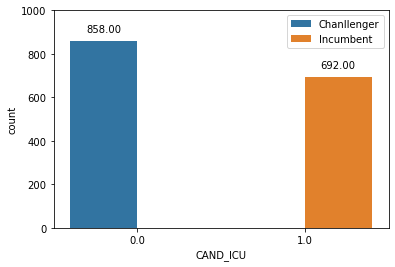

In [40]:
# Sort CAND_ICU, Incumbent(1), Otherwise(0)

fig,ax = plt.subplots()
fig.set_size_inches(14,81)
df_house_inc = df_house.withColumn('CAND_ICU', F.when(col('CAND_ICI') == 'I', 1.0).otherwise(0.0))
df_house_inc = df_house_inc.groupBy('CAND_ICU').count()
df_house_inc_pd = df_house_inc.select('*').toPandas() 
%matplotlib inline
plt.ylim(0, 1000)

labels=["Chanllenger", "Incumbent"]

ax = sn.barplot(x='CAND_ICU',y='count', hue=labels, data=df_house_inc_pd)
#ax.set(xticklabels=df_house_inc_pd['CAND_ICU'])

for p in ax.patches: 
    ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 12), 
                textcoords='offset points')
#plt.show()

Split into 2016, 2018 to add in features as they are year dependent

In [41]:
df_house16 = df_house.filter(df_house.CAND_ELECTION_YR == 2016)
df_house18 = df_house.filter(df_house.CAND_ELECTION_YR == 2018)

## Import Features

**2016:**

In [42]:
#reading in features 2016
avgsum_donation_16 = spark.read.csv('./features/avgsum_donation-16.csv', inferSchema=True, header=True)
num_big_donations_16 = spark.read.csv('./features/num_big_donations-16.csv', inferSchema=True, header=True)
num_out_of_state_donations_16 = spark.read.csv('./features/num_out_of_state_donations-16.csv', inferSchema=True, header=True)
numdonations16 = spark.read.csv('./features/numdonations16.csv', inferSchema=True, header=True)

**2018:**

In [43]:
#reading in features 2018
avgsum_donation_18 = spark.read.csv('./features/avgsum_donation-18.csv', inferSchema=True, header=True)
num_big_donations_18 = spark.read.csv('./features/num_big_donations-18.csv', inferSchema=True, header=True)
num_out_of_state_donations_18 = spark.read.csv('./features/num_out_of_state_donations-18.csv', inferSchema=True, header=True)
numdonations18 = spark.read.csv('./features/numdonations18.csv', inferSchema=True, header=True)

**2020:**

In [44]:
#reading in features 2020
avgsum_donation_20 = spark.read.csv('./features/avgsum_donation-20.csv', inferSchema=True, header=True)
num_big_donations_20 = spark.read.csv('./features/num_big_donations-20.csv', inferSchema=True, header=True)
num_out_of_state_donations_20 = spark.read.csv('./features/num_out_of_state_donations-20.csv', inferSchema=True, header=True)
numdonations20 = spark.read.csv('./features/numdonations20.csv', inferSchema=True, header=True)

## Join Candidates to Features

**2016:**

In [45]:
df_house16 = df_house16.join(avgsum_donation_16, on='CAND_ID', how='left')
df_house16 = df_house16.withColumnRenamed('avgdonation','AVERAGE_DONATION')
df_house16 = df_house16.withColumnRenamed('sumdonation','TOTAL_DONATIONS')
df_house16 = df_house16.drop(col('_c0'))

df_house16 = df_house16.join(num_big_donations_16, on='CAND_ID', how='left')
df_house16 = df_house16.withColumnRenamed('numdonat','NUMBER_BIG_DONATIONS')
df_house16 = df_house16.drop(col('_c0'))

df_house16 = df_house16.join(num_out_of_state_donations_16, on='CAND_ID', how='left')
df_house16 = df_house16.withColumnRenamed('numdonat','NUMBER_OUT_OF_STATE_DONATIONS')
df_house16 = df_house16.drop(col('_c0'))

df_house16 = df_house16.join(numdonations16, on='CAND_ID', how='left')
df_house16 = df_house16.withColumnRenamed('numdonat','NUMBER_OF_DONATIONS')
df_house16 = df_house16.drop(col('_c0'))

#identification based on existence, so filling na values with 0 where none found
df_house16 = df_house16.fillna({'NUMBER_BIG_DONATIONS':0, 'NUMBER_OUT_OF_STATE_DONATIONS':0})

#not not all candidates were able to join - filter out those without contribution info
df_house16 = df_house16.filter(col('TOTAL_DONATIONS').isNotNull())

#simpler filters
df_house16 = df_house16.withColumn('CONCAT', F.concat(col('CAND_ELECTION_YR'),F.lit('_'),col('CAND_OFFICE_ST'),F.lit('_'),col('CAND_OFFICE_DISTRICT')))

#identify races that only have information by CONCAT value
single_cand16 = df_house16.groupBy('CAND_ELECTION_YR','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT') \
                          .count() \
                          .filter('count == 1') \
                          .select('CAND_ELECTION_YR','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT') \
                          .withColumn('CONCAT', F.concat(col('CAND_ELECTION_YR'),F.lit('_'),col('CAND_OFFICE_ST'),F.lit('_'),col('CAND_OFFICE_DISTRICT'))) \
                          .select('CONCAT').rdd.flatMap(lambda x: x).collect()

#create list of 
all_cand16 = df_house16.select('CONCAT').rdd.flatMap(lambda x: x).collect()

#identifies from all races only those not single
multi_cand16 = [x for x in all_cand16 if x not in single_cand16]

#filter candidate pool to final form
df_house16 = df_house16.filter(col('CONCAT').isin(multi_cand16))


#calculate totals for various metrics
agg_total_donations16 = df_house16.groupBy('CONCAT').agg({'TOTAL_DONATIONS':'sum'}).withColumnRenamed('sum(TOTAL_DONATIONS)','AGG_TOTAL_DONATIONS')
df_house16 = df_house16.join(agg_total_donations16, on='CONCAT', how='left')

agg_number_big_donations16 = df_house16.groupBy('CONCAT').agg({'NUMBER_BIG_DONATIONS':'sum'}).withColumnRenamed('sum(NUMBER_BIG_DONATIONS)','AGG_NUMBER_BIG_DONATIONS')
df_house16 = df_house16.join(agg_number_big_donations16, on='CONCAT', how='left')

agg_number_out_of_state_donations16 = df_house16.groupBy('CONCAT').agg({'NUMBER_OUT_OF_STATE_DONATIONS':'sum'}).withColumnRenamed('sum(NUMBER_OUT_OF_STATE_DONATIONS)','AGG_NUMBER_OUT_OF_STATE_DONATIONS')
df_house16 = df_house16.join(agg_number_out_of_state_donations16, on='CONCAT', how='left')

agg_number_of_donations16 = df_house16.groupBy('CONCAT').agg({'NUMBER_OF_DONATIONS':'sum'}).withColumnRenamed('sum(NUMBER_OF_DONATIONS)','AGG_NUMBER_OF_DONATIONS')
df_house16 = df_house16.join(agg_number_of_donations16, on='CONCAT', how='left')


#relative calculations between candidates for a given race
df_house16 = df_house16.withColumn('REL_TOTAL_DONATIONS', col('TOTAL_DONATIONS')/col('AGG_TOTAL_DONATIONS'))
df_house16 = df_house16.withColumn('REL_NUMBER_BIG_DONATIONS', col('NUMBER_BIG_DONATIONS')/col('AGG_NUMBER_BIG_DONATIONS'))
df_house16 = df_house16.withColumn('REL_NUMBER_OUT_OF_STATE_DONATIONS', col('NUMBER_OUT_OF_STATE_DONATIONS')/col('AGG_NUMBER_OUT_OF_STATE_DONATIONS'))
df_house16 = df_house16.withColumn('REL_NUMBER_OF_DONATIONS', col('NUMBER_OF_DONATIONS')/col('AGG_NUMBER_OF_DONATIONS'))
df_house16 = df_house16.withColumn('PERCENT_BIG_DONATIONS', col('NUMBER_BIG_DONATIONS')/col('NUMBER_OF_DONATIONS'))
df_house16 = df_house16.withColumn('PERCENT_OUT_OF_STATE_DONATIONS', col('NUMBER_OUT_OF_STATE_DONATIONS')/col('NUMBER_OF_DONATIONS'))


In [46]:
df_house16.count()

502

In [47]:
df_house16_pd= df_house16.select('*').toPandas() 

aggregation_functions = {'TOTAL_VOTES':'sum','TOTAL_DONATIONS': 'sum','NUMBER_BIG_DONATIONS': 'sum', 'NUMBER_OUT_OF_STATE_DONATIONS': 'sum', 'NUMBER_OF_DONATIONS': 'sum'}

df_house16_pd=  df_house16_pd.groupby(df_house16_pd['CAND_OFFICE_ST']).aggregate(aggregation_functions).reset_index()

df_house16_pd['AVG_DONATIONS'] = (df_house16_pd['TOTAL_DONATIONS'])/(df_house16_pd['NUMBER_OF_DONATIONS'])
#df_house16_pd.sort_values(by=['TOTAL_DONATIONS'])

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3695: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



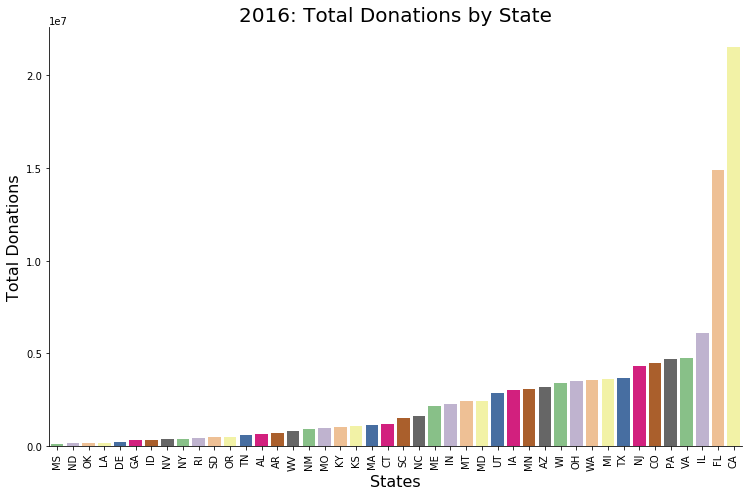

In [48]:
# Sort 2016 total donations by state
df_house16_pd=df_house16_pd.sort_values(by=['TOTAL_DONATIONS'])
# Plot bar graph 
a = sn.catplot("CAND_OFFICE_ST", "TOTAL_DONATIONS", data=df_house16_pd, kind="bar", size=7, aspect=1.5, legend=False, palette="Accent")
a.set_xticklabels(rotation=90)

plt.title('2016: Total Donations by State', size= "20")
plt.xlabel('States',size= "16")

plt.ylabel('Total Donations',size= "16")          
plt.tight_layout()
plt.show()

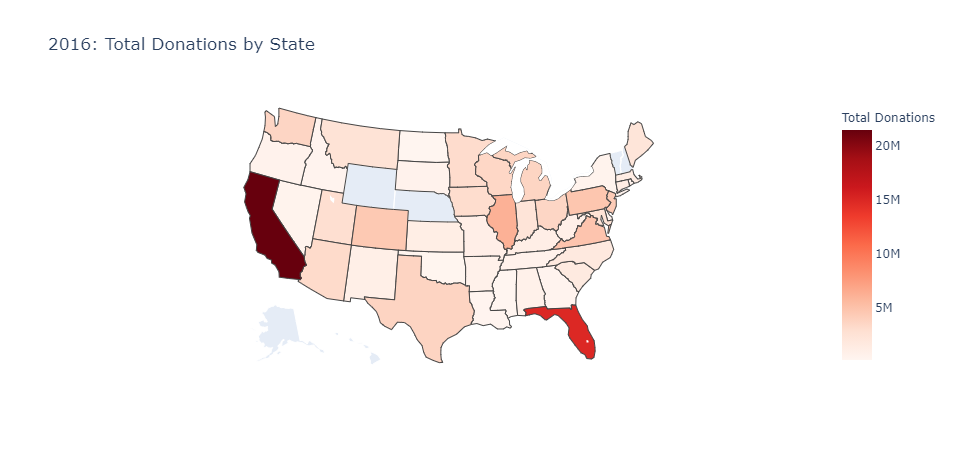

In [49]:
fig = go.Figure(data=go.Choropleth(
    locations=df_house16_pd.CAND_OFFICE_ST, # Spatial coordinates
    z = df_house16_pd.TOTAL_DONATIONS, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Total Donations",
))

fig.update_layout(
    title_text = '2016: Total Donations by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3695: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



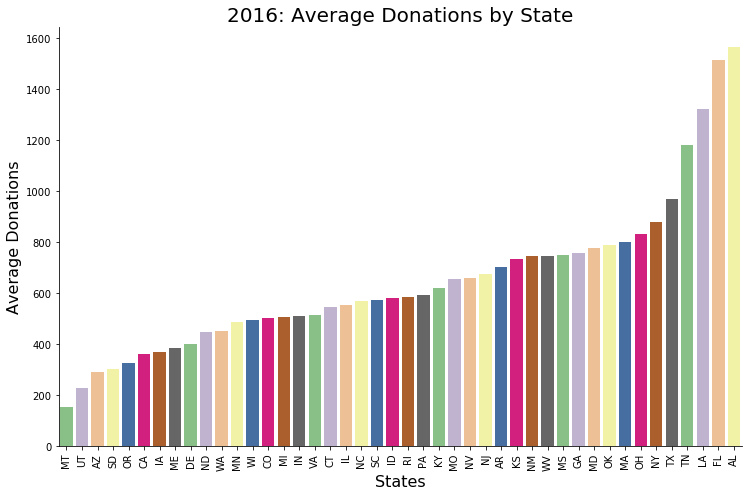

In [50]:
# Sort 2016 states by average donations
df_house16_pd=df_house16_pd.sort_values(by=['AVG_DONATIONS'])
# Plot bar graph 
a = sn.catplot("CAND_OFFICE_ST", "AVG_DONATIONS", data=df_house16_pd, kind="bar", size=7, aspect=1.5, legend=False, palette="Accent")
a.set_xticklabels(rotation=90)

plt.title('2016: Average Donations by State', size= "20")
plt.xlabel('States',size= "16")

plt.ylabel('Average Donations',size= "16")          
plt.tight_layout()
plt.show()

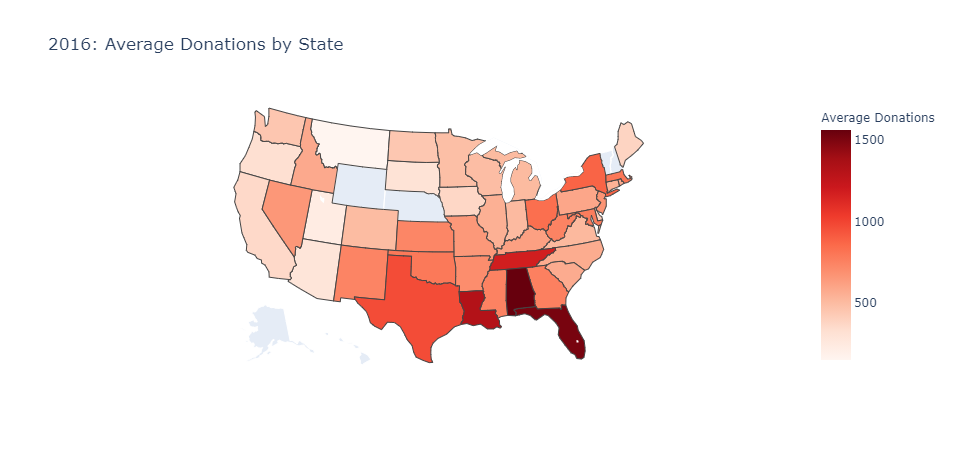

In [51]:
fig = go.Figure(data=go.Choropleth(
    locations=df_house16_pd.CAND_OFFICE_ST, # Spatial coordinates
    z = df_house16_pd.AVG_DONATIONS, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Average Donations",
))

fig.update_layout(
    title_text = '2016: Average Donations by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3695: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



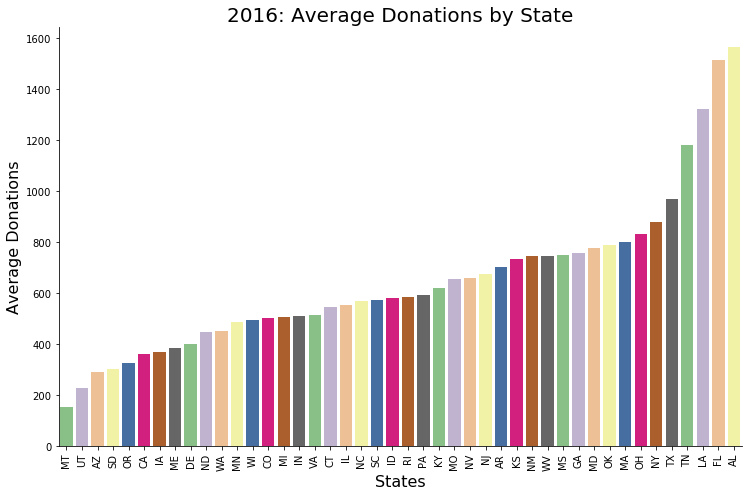

In [52]:
# Sort 2016&2018 states by number of donations
df_house16_pd=df_house16_pd.sort_values(by=['AVG_DONATIONS'])
# Plot bar graph 
a = sn.catplot("CAND_OFFICE_ST", "AVG_DONATIONS", data=df_house16_pd, kind="bar", size=7, aspect=1.5, legend=False, palette="Accent")
a.set_xticklabels(rotation=90)

plt.title('2016: Average Donations by State', size= "20")
plt.xlabel('States',size= "16")

plt.ylabel('Average Donations',size= "16")          
plt.tight_layout()
plt.show()

**2018:**

In [53]:
df_house18 = df_house18.join(avgsum_donation_18, on='CAND_ID', how='left')
df_house18 = df_house18.withColumnRenamed('avgdonation','AVERAGE_DONATION')
df_house18 = df_house18.withColumnRenamed('sumdonation','TOTAL_DONATIONS')
df_house18 = df_house18.drop(col('_c0'))

df_house18 = df_house18.join(num_big_donations_18, on='CAND_ID', how='left')
df_house18 = df_house18.withColumnRenamed('numdonat','NUMBER_BIG_DONATIONS')
df_house18 = df_house18.drop(col('_c0'))

df_house18 = df_house18.join(num_out_of_state_donations_18, on='CAND_ID', how='left')
df_house18 = df_house18.withColumnRenamed('numdonat','NUMBER_OUT_OF_STATE_DONATIONS')
df_house18 = df_house18.drop(col('_c0'))

df_house18 = df_house18.join(numdonations18, on='CAND_ID', how='left')
df_house18 = df_house18.withColumnRenamed('numdonat','NUMBER_OF_DONATIONS')
df_house18 = df_house18.drop(col('_c0'))

#identification based on existence, so filling na values with 0 where none found
df_house18 = df_house18.fillna({'NUMBER_BIG_DONATIONS':0, 'NUMBER_OUT_OF_STATE_DONATIONS':0})

#not not all candidates were able to join - filter out those without contribution info
df_house18 = df_house18.filter(col('TOTAL_DONATIONS').isNotNull())

#simpler filters
df_house18 = df_house18.withColumn('CONCAT', F.concat(col('CAND_ELECTION_YR'),F.lit('_'),col('CAND_OFFICE_ST'),F.lit('_'),col('CAND_OFFICE_DISTRICT')))

###

#identify races that only have information by CONCAT value
single_cand18 = df_house18.groupBy('CAND_ELECTION_YR','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT') \
                          .count() \
                          .filter('count == 1') \
                          .select('CAND_ELECTION_YR','CAND_OFFICE_ST','CAND_OFFICE_DISTRICT') \
                          .withColumn('CONCAT', F.concat(col('CAND_ELECTION_YR'),F.lit('_'),col('CAND_OFFICE_ST'),F.lit('_'),col('CAND_OFFICE_DISTRICT'))) \
                          .select('CONCAT').rdd.flatMap(lambda x: x).collect()

#create list of all candidate races
all_cand18 = df_house18.select('CONCAT').rdd.flatMap(lambda x: x).collect()

#identifies from all races only those not single
multi_cand18 = [x for x in all_cand18 if x not in single_cand18]

#filter candidate pool to final form
df_house18 = df_house18.filter(col('CONCAT').isin(multi_cand18))

###

#calculate totals for various metrics
agg_total_donations18 = df_house18.groupBy('CONCAT').agg({'TOTAL_DONATIONS':'sum'}).withColumnRenamed('sum(TOTAL_DONATIONS)','AGG_TOTAL_DONATIONS')
df_house18 = df_house18.join(agg_total_donations18, on='CONCAT', how='left')

agg_number_big_donations18 = df_house18.groupBy('CONCAT').agg({'NUMBER_BIG_DONATIONS':'sum'}).withColumnRenamed('sum(NUMBER_BIG_DONATIONS)','AGG_NUMBER_BIG_DONATIONS')
df_house18 = df_house18.join(agg_number_big_donations18, on='CONCAT', how='left')

agg_number_out_of_state_donations18 = df_house18.groupBy('CONCAT').agg({'NUMBER_OUT_OF_STATE_DONATIONS':'sum'}).withColumnRenamed('sum(NUMBER_OUT_OF_STATE_DONATIONS)','AGG_NUMBER_OUT_OF_STATE_DONATIONS')
df_house18 = df_house18.join(agg_number_out_of_state_donations18, on='CONCAT', how='left')

agg_number_of_donations18 = df_house18.groupBy('CONCAT').agg({'NUMBER_OF_DONATIONS':'sum'}).withColumnRenamed('sum(NUMBER_OF_DONATIONS)','AGG_NUMBER_OF_DONATIONS')
df_house18 = df_house18.join(agg_number_of_donations18, on='CONCAT', how='left')

#relative calculations between candidates for a given race
df_house18 = df_house18.withColumn('REL_TOTAL_DONATIONS', col('TOTAL_DONATIONS')/col('AGG_TOTAL_DONATIONS'))
df_house18 = df_house18.withColumn('REL_NUMBER_BIG_DONATIONS', col('NUMBER_BIG_DONATIONS')/col('AGG_NUMBER_BIG_DONATIONS'))
df_house18 = df_house18.withColumn('REL_NUMBER_OUT_OF_STATE_DONATIONS', col('NUMBER_OUT_OF_STATE_DONATIONS')/col('AGG_NUMBER_OUT_OF_STATE_DONATIONS'))
df_house18 = df_house18.withColumn('REL_NUMBER_OF_DONATIONS', col('NUMBER_OF_DONATIONS')/col('AGG_NUMBER_OF_DONATIONS'))
df_house18 = df_house18.withColumn('PERCENT_BIG_DONATIONS', col('NUMBER_BIG_DONATIONS')/col('NUMBER_OF_DONATIONS'))
df_house18 = df_house18.withColumn('PERCENT_OUT_OF_STATE_DONATIONS', col('NUMBER_OUT_OF_STATE_DONATIONS')/col('NUMBER_OF_DONATIONS'))


In [54]:
df_house18.count()

678

In [59]:
#df_house18_pd= df_house18.select('*').toPandas() 
#df_test=df_house18_pd.loc[(df_house18_pd['CAND_OFFICE_ST']=='CA')& ((df_house18_pd['CAND_NAME']=='MATTA, TATIANA'))]#| (df_house18_pd['CAND_NAME']=='MCCARTHY, KEVIN'))]
#df_test=df_house18_pd.loc[(df_house18_pd['CAND_OFFICE_ST']=='WY')]
#df_test

df_house18_pd= df_house18.select('*').toPandas() 

aggregation_functions = {'TOTAL_VOTES':'sum','TOTAL_DONATIONS': 'sum','NUMBER_BIG_DONATIONS': 'sum', 'NUMBER_OUT_OF_STATE_DONATIONS': 'sum', 'NUMBER_OF_DONATIONS': 'sum'}

df_house18_pd=  df_house18_pd.groupby(df_house18_pd['CAND_OFFICE_ST']).aggregate(aggregation_functions).reset_index()

df_house18_pd['AVG_DONATIONS'] = (df_house18_pd['TOTAL_DONATIONS'])/(df_house18_pd['NUMBER_OF_DONATIONS'])


/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3695: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



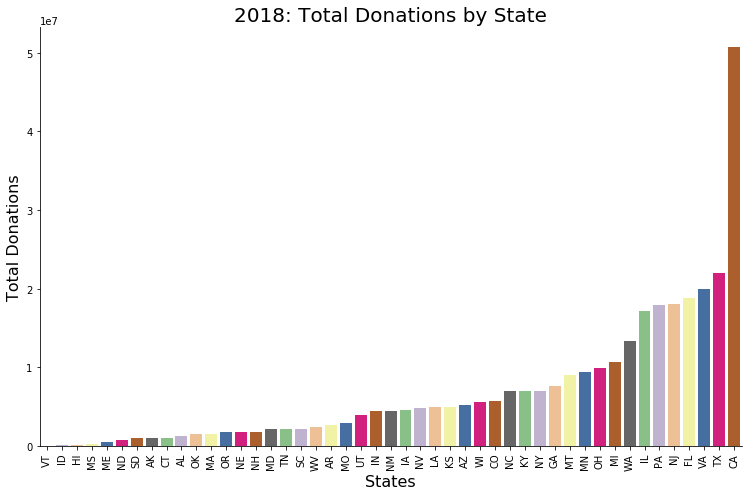

In [60]:
# Sort 2018 total votes data by total donations
df_house18_pd=df_house18_pd.sort_values(by=['TOTAL_DONATIONS'])
# Plot bar graph 
a = sn.catplot("CAND_OFFICE_ST", "TOTAL_DONATIONS", data=df_house18_pd, kind="bar", size=7, aspect=1.5, legend=False, palette="Accent")
a.set_xticklabels(rotation=90)

plt.title('2018: Total Donations by State', size= "20")
plt.xlabel('States',size= "16")

plt.ylabel('Total Donations',size= "16")          
plt.tight_layout()
plt.show()

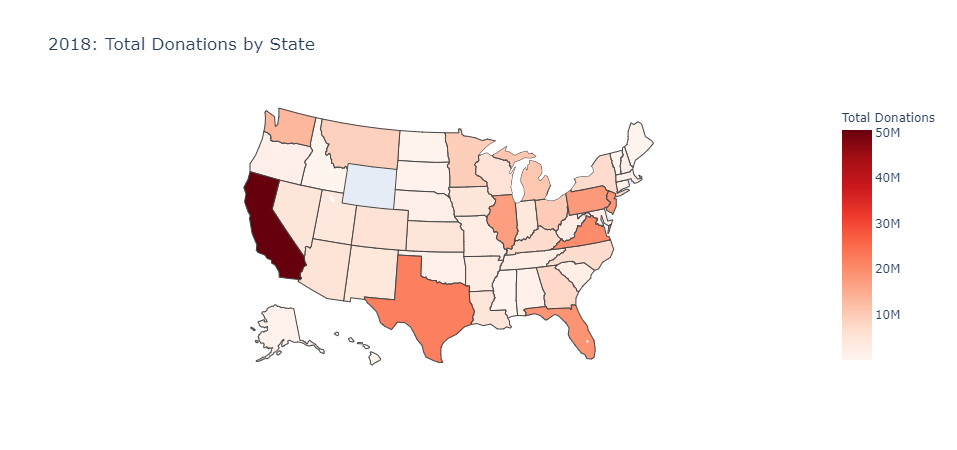

In [61]:
fig = go.Figure(data=go.Choropleth(
    locations=df_house18_pd.CAND_OFFICE_ST, # Spatial coordinates
    z = df_house18_pd.TOTAL_DONATIONS, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Total Donations",
))

fig.update_layout(
    title_text = '2018: Total Donations by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3695: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



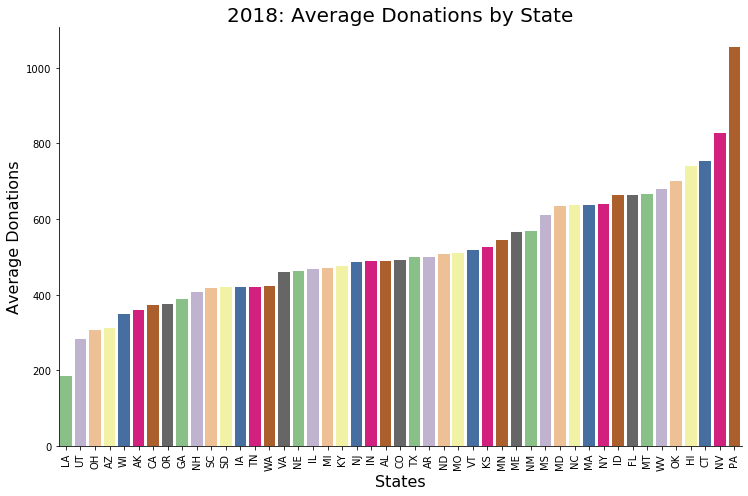

In [62]:
# Sort 2018 total votes data by average donations
df_house18_pd=df_house18_pd.sort_values(by=['AVG_DONATIONS'])
# Plot bar graph 
a = sn.catplot("CAND_OFFICE_ST", "AVG_DONATIONS", data=df_house18_pd, kind="bar", size=7, aspect=1.5, legend=False, palette="Accent")
a.set_xticklabels(rotation=90)

plt.title('2018: Average Donations by State', size= "20")
plt.xlabel('States',size= "16")

plt.ylabel('Average Donations',size= "16")          
plt.tight_layout()
plt.show()

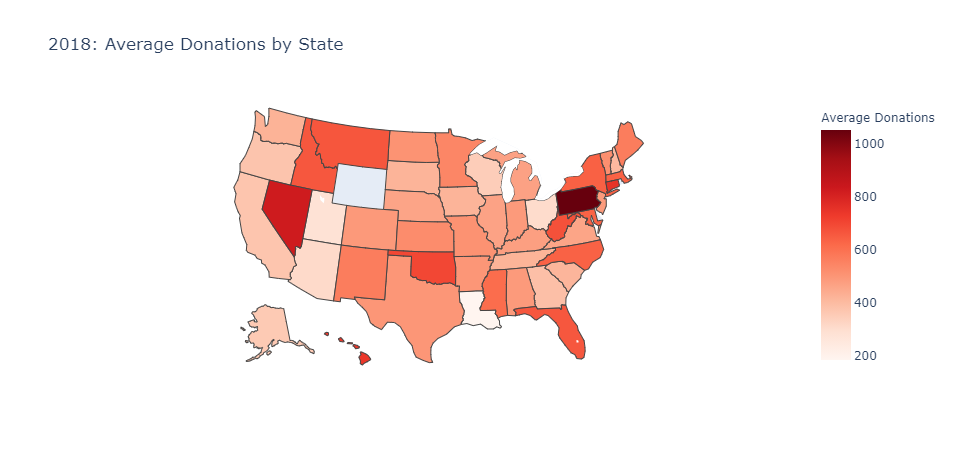

In [63]:
fig = go.Figure(data=go.Choropleth(
    locations=df_house18_pd.CAND_OFFICE_ST, # Spatial coordinates
    z = df_house18_pd.AVG_DONATIONS, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Average Donations",
))

fig.update_layout(
    title_text = '2018: Average Donations by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

In [64]:
#print(df_house18_pd.columns.tolist())

**Combine 2016 and 2018:**

In [65]:
df_house = reduce(DataFrame.unionAll, [df_house16, df_house18])

In [66]:
df_house.printSchema()

root
 |-- CONCAT: string (nullable = true)
 |-- CAND_ID: string (nullable = true)
 |-- CAND_NAME: string (nullable = true)
 |-- CAND_PTY_AFFILIATION: string (nullable = true)
 |-- CAND_ELECTION_YR: integer (nullable = true)
 |-- CAND_OFFICE_ST: string (nullable = true)
 |-- CAND_OFFICE: string (nullable = true)
 |-- CAND_OFFICE_DISTRICT: double (nullable = true)
 |-- CAND_ICI: string (nullable = true)
 |-- CAND_STATUS: string (nullable = true)
 |-- CAND_PCC: string (nullable = true)
 |-- CAND_CITY: string (nullable = true)
 |-- CAND_ST: string (nullable = true)
 |-- CAND_ZIP: double (nullable = true)
 |-- CAND_VOTES: integer (nullable = true)
 |-- TOTAL_VOTES: integer (nullable = true)
 |-- PERCENT_VOTES: double (nullable = true)
 |-- WINNER: integer (nullable = true)
 |-- CAND_ICU: double (nullable = false)
 |-- AVERAGE_DONATION: double (nullable = true)
 |-- TOTAL_DONATIONS: double (nullable = true)
 |-- NUMBER_BIG_DONATIONS: integer (nullable = false)
 |-- NUMBER_OUT_OF_STATE_DONATI

In [67]:
df_house.count()

1180

In [68]:
df_house_pd = df_house.select(df_house.columns[14:]).toPandas() 

In [69]:
corrMatrix = df_house_pd.corr()
corrMatrix

CAND_VOTES  TOTAL_VOTES  PERCENT_VOTES  \
CAND_VOTES                           1.000000     0.429055       0.858076   
TOTAL_VOTES                          0.429055     1.000000      -0.047671   
PERCENT_VOTES                        0.858076    -0.047671       1.000000   
WINNER                               0.700544    -0.015432       0.799186   
CAND_ICU                             0.608876    -0.014362       0.694079   
AVERAGE_DONATION                     0.007145     0.035187      -0.005463   
TOTAL_DONATIONS                      0.213473     0.113273       0.171105   
NUMBER_BIG_DONATIONS                 0.232323     0.105508       0.196514   
NUMBER_OUT_OF_STATE_DONATIONS        0.124934     0.061530       0.101617   
NUMBER_OF_DONATIONS                  0.171593     0.092843       0.135540   
AGG_TOTAL_DONATIONS                  0.040724     0.165675      -0.033344   
AGG_NUMBER_BIG_DONATIONS             0.037174     0.150778      -0.031266   
AGG_NUMBER_OUT_OF_STATE_DONATIONS   -0.001114     0.073828      -0.044300   
AGG_NUMBER_OF_DONATIONS              0.035772     0.126356      -0.026135   
REL_TOTAL_DONATIONS                  0.683607    -0.022481       0.782797   
REL_NUMBER_BIG_DONATIONS             0.694127    -0.022401       0.794869   
REL_NUMBER_OUT_OF_STATE_DONATIONS    0.585750    -0.020289       0.674255   
REL_NUMBER_OF_DONATIONS              0.578782    -0.022578       0.660857   
PERCENT_BIG_DONATIONS                0.167568    -0.133388       0.259936   
PERCENT_OUT_OF_STATE_DONATIONS       0.175181     0.012627       0.183770   

                                     WINNER  CAND_ICU  AVERAGE_DONATION  \
CAND_VOTES                         0.700544  0.608876          0.007145   
TOTAL_VOTES                       -0.015432 -0.014362          0.035187   
PERCENT_VOTES                      0.799186  0.694079         -0.005463   
WINNER                             1.000000  0.776139          0.005573   
CAND_ICU                           0.776139  1.000000          0.012733   
AVERAGE_DONATION                   0.005573  0.012733          1.000000   
TOTAL_DONATIONS                    0.143200 -0.000645          0.247743   
NUMBER_BIG_DONATIONS               0.179629  0.010255         -0.039309   
NUMBER_OUT_OF_STATE_DONATIONS      0.055448  0.014571         -0.052928   
NUMBER_OF_DONATIONS                0.082836 -0.015493         -0.072479   
AGG_TOTAL_DONATIONS               -0.018081 -0.057550          0.138023   
AGG_NUMBER_BIG_DONATIONS          -0.017335 -0.050754         -0.025304   
AGG_NUMBER_OUT_OF_STATE_DONATIONS -0.018659 -0.020346         -0.027057   
AGG_NUMBER_OF_DONATIONS           -0.014257 -0.021697         -0.042827   
REL_TOTAL_DONATIONS                0.736673  0.613337          0.069140   
REL_NUMBER_BIG_DONATIONS           0.746936  0.615672         -0.010266   
REL_NUMBER_OUT_OF_STATE_DONATIONS  0.605974  0.482399         -0.052815   
REL_NUMBER_OF_DONATIONS            0.566306  0.438633         -0.069862   
PERCENT_BIG_DONATIONS              0.313888  0.319815          0.270455   
PERCENT_OUT_OF_STATE_DONATIONS     0.174559  0.147422          0.001389   

                                   TOTAL_DONATIONS  NUMBER_BIG_DONATIONS  \
CAND_VOTES                                0.213473              0.232323   
TOTAL_VOTES                               0.113273              0.105508   
PERCENT_VOTES                             0.171105              0.196514   
WINNER                                    0.143200              0.179629   
CAND_ICU                                 -0.000645              0.010255   
AVERAGE_DONATION                          0.247743             -0.039309   
TOTAL_DONATIONS                           1.000000              0.870432   
NUMBER_BIG_DONATIONS                      0.870432              1.000000   
NUMBER_OUT_OF_STATE_DONATIONS             0.503067              0.548795   
NUMBER_OF_DONATIONS                       0.701611              0.787958   
AGG_T

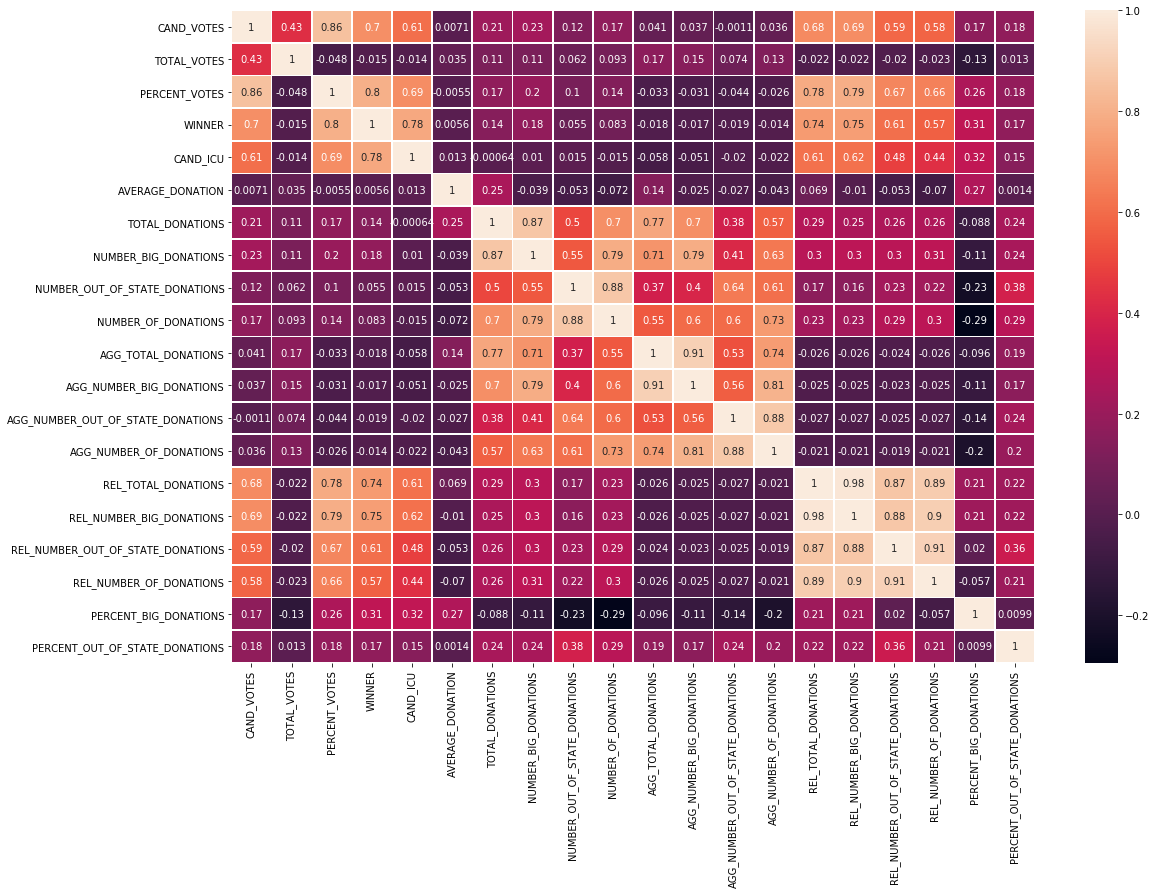

In [70]:
fig, ax = plt.subplots(figsize=(18,12))
sn.heatmap(corrMatrix, annot=True, linewidths=.8, ax=ax)
plt.show()

In [71]:
df_house_pd_all = df_house.select('*').toPandas() 
df_house_pd_all

CONCAT    CAND_ID                   CAND_NAME  \
0     2016_OH_10.0  H2OH03067           TURNER, MICHAEL R   
1     2016_OH_10.0  H4OH10167         KLEPINGER, ROBERT P   
2     2016_OH_10.0  H6OH10113           MCMASTERS, THOMAS   
3      2016_VA_4.0  H6VA04061  MCEACHIN, ASTON DONALD MR.   
4      2016_VA_4.0  H6VA07130           WADE, MICHAEL LEO   
...            ...        ...                         ...   
1175  2018_NY_14.0  H8NY15148   OCASIO-CORTEZ, ALEXANDRIA   
1176  2018_IL_17.0  H4IL17077           FAWELL, WILLIAM W   
1177  2018_IL_17.0  H2IL17071               BUSTOS, CHERI   
1178   2018_KY_4.0  H8KY04169            HALL, SETH BLANE   
1179   2018_KY_4.0  H2KY04121           MASSIE, THOMAS H.   

     CAND_PTY_AFFILIATION  CAND_ELECTION_YR CAND_OFFICE_ST CAND_OFFICE  \
0                     REP              2016             OH           H   
1                     DEM              2016             OH           H   
2                      UN              2016             OH           H   
3                     DEM              2016             VA           H   
4                     REP              2016             VA           H   
...                   ...               ...            ...         ...   
1175                  DEM              2018             NY           H   
1176                  REP              2018             IL           H   
1177                  DEM              2018             IL           H   
1178                  DEM              2018             KY           H   
1179                  REP              2018             KY           H   

      CAND_OFFICE_DISTRICT CAND_ICI CAND_STATUS  ... AGG_TOTAL_DONATIONS  \
0                     10.0        I           C  ...            230863.0   
1                     10.0        C           N  ...            230863.0   
2                     10.0        C           P  ...            230863.0   
3                      4.0        C           C  ...            263925.0   
4                      4.0        C           P  ...            263925.0   
...                    ...      ...         ...  ...                 ...   
1175                  14.0        C           C  ...           1105364.0   
1176                  17.0        C           C  ...            805489.0   
1177                  17.0        I           C  ...            805489.0   
1178                   4.0        C           C  ...             82768.0   
1179                   4.0        I           C  ...             82768.0   

     AGG_NUMBER_BIG_DONATIONS AGG_NUMBER_OUT_OF_STATE_DONATIONS  \
0                         118                                38   
1                         118                                38   
2                         118                                38   
3                         204                                42   
4                         204                                42   
...                       ...                               ...   
1175                      679                              2144   
1176                      631                              3376   
1177                      631                              3376   
1178                       63                                30   
1179                       63                                30   

      AGG_NUMBER_OF_DONATIONS  REL_TOTAL_DONATIONS  REL_NUMBER_BIG_DONATIONS  \
0                         197             0.894812                  0.957627   
1                         197             0.009529                  0.016949   
2                         197             0.095658                  0.025424   
3                         440             0.785287                  0.784314   
4                         440             0.214713                  0.215686   
...                       ...                  ...                       ...   
1175                     2347             0.479434                  0.634757   
1176                     5160   

In [72]:
#list(df_house_pd_all.columns.values)


In [73]:
aggregation_functions = {'TOTAL_VOTES':'sum','TOTAL_DONATIONS': 'sum','NUMBER_BIG_DONATIONS': 'sum', 'NUMBER_OUT_OF_STATE_DONATIONS': 'sum', 'NUMBER_OF_DONATIONS': 'sum'}
df_house_pd_all=  df_house_pd_all.groupby(df_house_pd_all['CAND_OFFICE_ST']).aggregate(aggregation_functions).reset_index()
df_house_pd_all['AVG_DONATIONS'] = (df_house_pd_all['TOTAL_DONATIONS'])/(df_house_pd_all['NUMBER_OF_DONATIONS'])

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3695: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



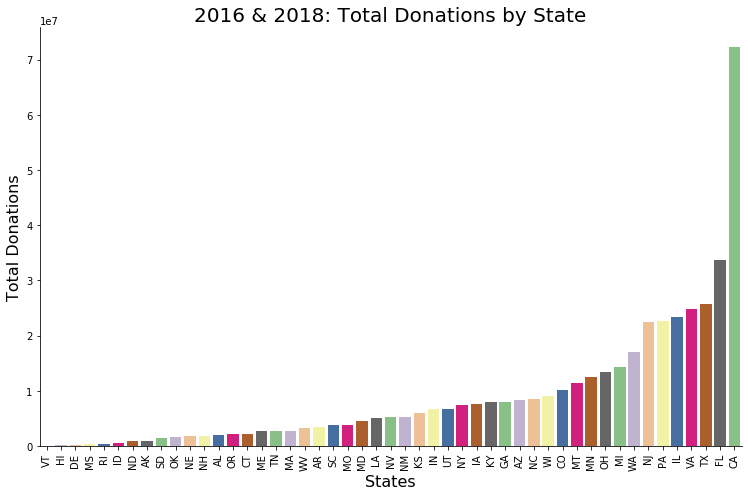

In [74]:
df_house_pd_all=df_house_pd_all.sort_values(by=['TOTAL_DONATIONS'])
# Plot bar graph 
a = sn.catplot("CAND_OFFICE_ST", "TOTAL_DONATIONS", data=df_house_pd_all, kind="bar", size=7, aspect=1.5, legend=False, palette="Accent")
a.set_xticklabels(rotation=90)

plt.title('2016 & 2018: Total Donations by State', size= "20")
plt.xlabel('States',size= "16")

plt.ylabel('Total Donations',size= "16")          
plt.tight_layout()
plt.show()

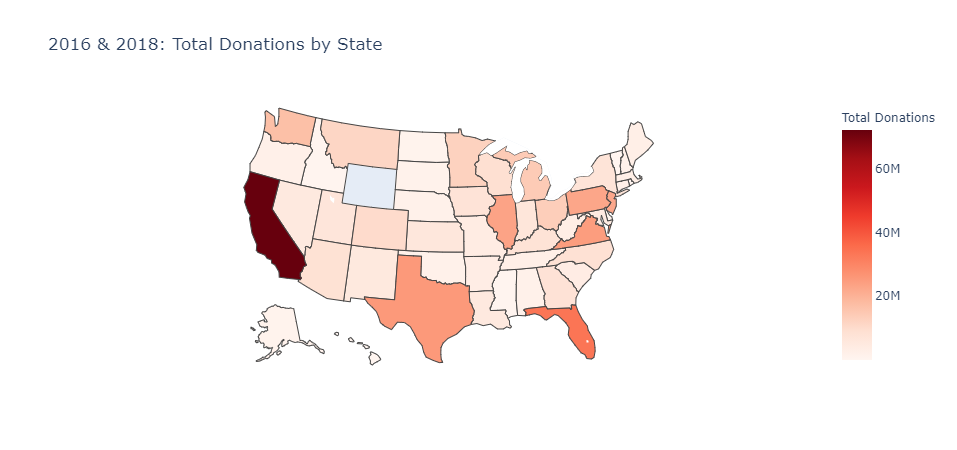

In [75]:
fig = go.Figure(data=go.Choropleth(
    locations=df_house_pd_all.CAND_OFFICE_ST, # Spatial coordinates
    z = df_house_pd_all.TOTAL_DONATIONS, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Total Donations",
))

fig.update_layout(
    title_text = '2016 & 2018: Total Donations by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

### No 2016 & 2018 donation data for WY (blue in map)

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3695: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



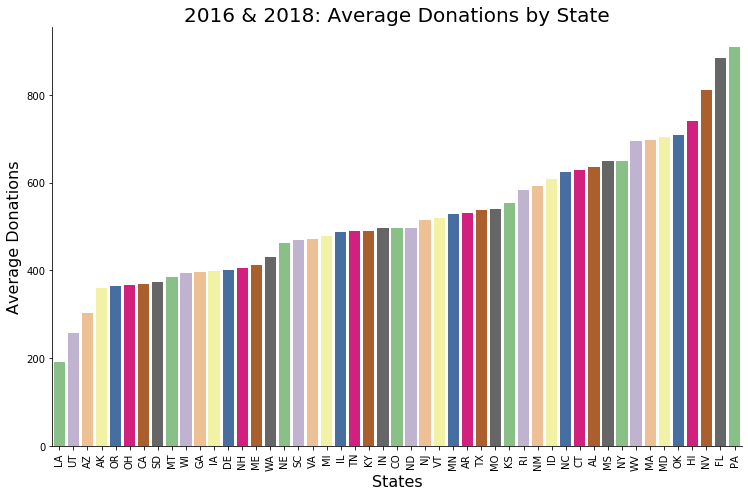

In [80]:
# Sort 2016 & 2018 total donations by state
df_house_pd_all=df_house_pd_all.sort_values(by=['AVG_DONATIONS'])
# Plot bar graph 
a = sn.catplot("CAND_OFFICE_ST", "AVG_DONATIONS", data=df_house_pd_all, kind="bar", size=7, aspect=1.5, legend=False, palette="Accent")
a.set_xticklabels(rotation=90)

plt.title('2016 & 2018: Average Donations by State', size= "20")
plt.xlabel('States',size= "16")

plt.ylabel('Average Donations',size= "16")          
plt.tight_layout()
plt.show()

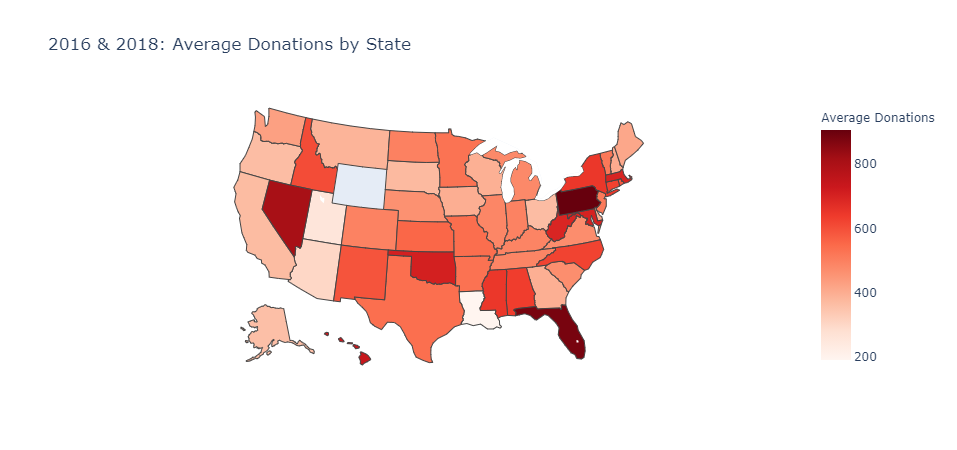

In [81]:
fig = go.Figure(data=go.Choropleth(
    locations=df_house_pd_all.CAND_OFFICE_ST, # Spatial coordinates
    z = df_house_pd_all.AVG_DONATIONS, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "Average Donations",
))

fig.update_layout(
    title_text = '2016 & 2018: Average Donations by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3695: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.



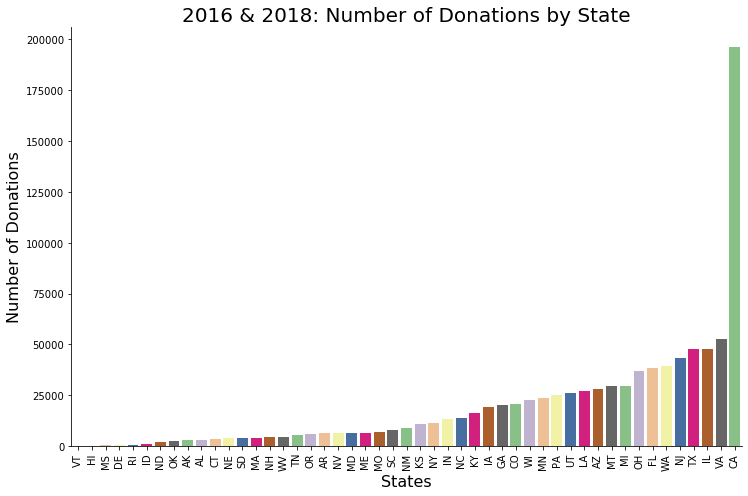

In [82]:
# Sort 2016 & 2018 total donations by state
df_house_pd_all=df_house_pd_all.sort_values(by=['NUMBER_OF_DONATIONS'])
# Plot bar graph 
a = sn.catplot("CAND_OFFICE_ST", "NUMBER_OF_DONATIONS", data=df_house_pd_all, kind="bar", size=7, aspect=1.5, legend=False, palette="Accent")
a.set_xticklabels(rotation=90)

plt.title('2016 & 2018: Number of Donations by State', size= "20")
plt.xlabel('States',size= "16")

plt.ylabel('Number of Donations',size= "16")          
plt.tight_layout()
plt.show()

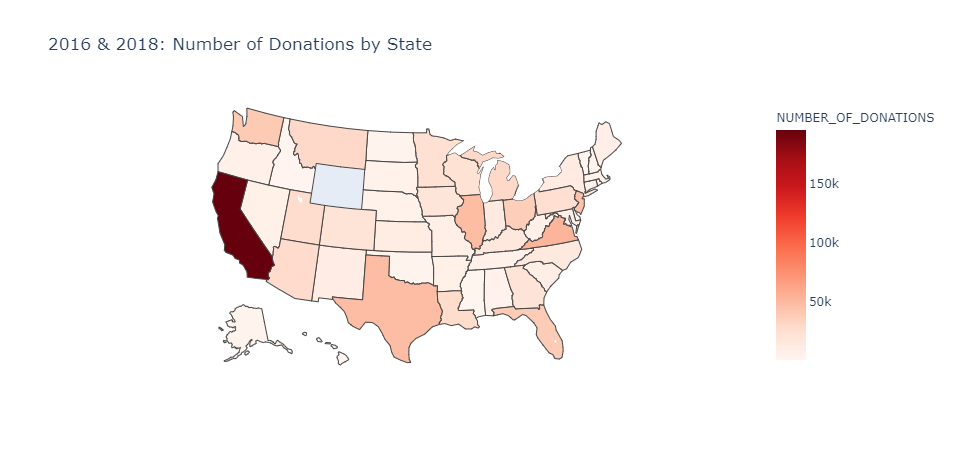

In [83]:
fig = go.Figure(data=go.Choropleth(
    locations=df_house_pd_all.CAND_OFFICE_ST, # Spatial coordinates
    z = df_house_pd_all.NUMBER_OF_DONATIONS, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "NUMBER_OF_DONATIONS",
))

fig.update_layout(
    title_text = '2016 & 2018: Number of Donations by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

## Graphical Data Exploration:

Histogram of Relative Total Donations - overlay incumbent receipts/challenger receipts

In [23]:
incumbent_donations_rel = list(df_house.filter('CAND_ICU == 1.0').select('REL_TOTAL_DONATIONS').rdd.map(lambda row: row[0]).collect())
challenger_donations_rel = list(df_house.filter('CAND_ICU == 0.0').select('REL_TOTAL_DONATIONS').rdd.map(lambda row: row[0]).collect())
all_donations = list(df_house.select('TOTAL_DONATIONS').rdd.map(lambda row: row[0]).collect())

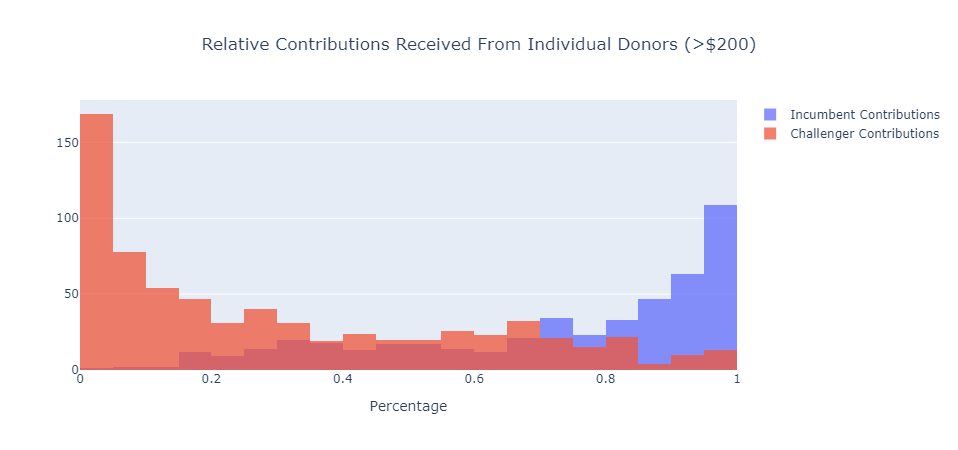

In [24]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(x=incumbent_donations_rel, name='Incumbent Contributions', xbins = dict(start='0')))
fig.add_trace(go.Histogram(x=challenger_donations_rel, name = 'Challenger Contributions', xbins = dict(start='0')))


#xbins = dict(start='0',end='500000',size= 50000)

# Overlay both histograms
fig.update_layout(barmode='overlay', 
                  title_text='Relative Contributions Received From Individual Donors (>$200)', 
                  title_x=0.5,
                  xaxis_title ='Percentage')

# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.show()

Box Plot of Total Donations - by incumbent receipts/challenger receipts

In [25]:
incumbent_donations_dol = list(df_house.filter('CAND_ICU == 1.0').select('TOTAL_DONATIONS').rdd.map(lambda row: row[0]).collect())
challenger_donations_dol = list(df_house.filter('CAND_ICU == 0.0').select('TOTAL_DONATIONS').rdd.map(lambda row: row[0]).collect())

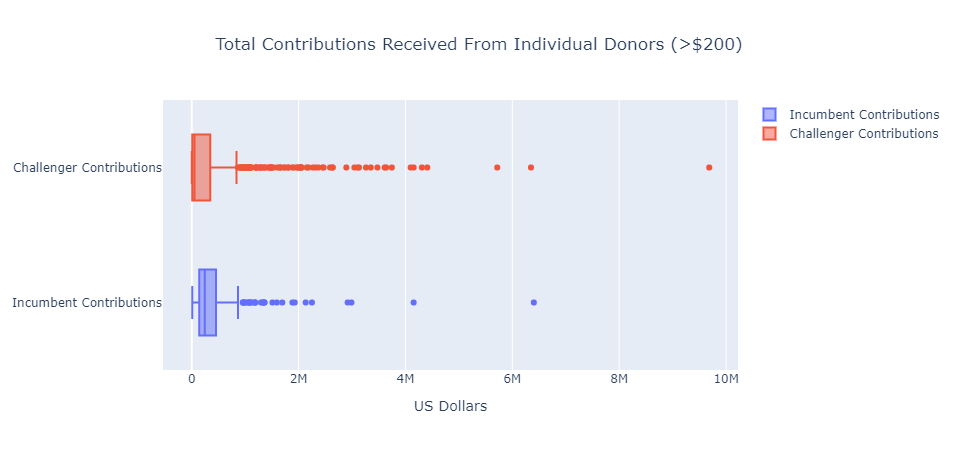

In [26]:
fig = go.Figure()
fig.add_trace(go.Box(x=incumbent_donations_dol, name='Incumbent Contributions'))
fig.add_trace(go.Box(x=challenger_donations_dol, name='Challenger Contributions'))

fig.update_layout(title_text='Total Contributions Received From Individual Donors (>$200)',
                  title_x=0.5,
                  xaxis_title='US Dollars')

fig.show()

Choropleth Map Showing Candidate Counts by State

In [27]:
candidate_locations = df_house.groupBy('CAND_OFFICE_ST').count().toPandas()

In [ ]:
# fig = go.Figure(data=go.Choropleth(
#     locations=candidate_locations['CAND_OFFICE_ST'], # Spatial coordinates
#     z = candidate_locations['count'], # Data to be color-coded
#     locationmode = 'USA-states', # set of locations match entries in `locations`
#     colorscale = 'Blues',
#     colorbar_title = "Candidate Number",
# ))

# fig.update_layout(
#     title_text = '2016 & 2018 Candidates in Races by State',
#     geo_scope='usa', # limite map scope to USA
# )

# fig.show()

---
---
# **Model Preparation:**

---
#### General Inputs for **Classification** Model:  
Defines what variables will be considered and the train/test split

In [15]:
SEED = 1
training_fraction = [0.8, 0.2]
ITERS = 5
target = 'WINNER'
vars_to_keep = ['CAND_ICU','REL_TOTAL_DONATIONS',
                'REL_NUMBER_OF_DONATIONS',
                'REL_NUMBER_BIG_DONATIONS',
                'REL_NUMBER_OUT_OF_STATE_DONATIONS',
                'PERCENT_BIG_DONATIONS',
                'PERCENT_OUT_OF_STATE_DONATIONS']
df_model = df_house.select([target]+vars_to_keep)

#### Check positive/negative balance of data set:  
Relatively balanced, no down/up-sampling required

In [16]:
#relatively balanced data set
df_model.groupBy(target).count().show()

+------+-----+
|WINNER|count|
+------+-----+
|     1|  560|
|     0|  620|
+------+-----+



In [18]:
train.groupBy(target).count().show()

+------+-----+
|WINNER|count|
+------+-----+
|     1|  446|
|     0|  489|
+------+-----+



---
# Identify **benchmark** classification model:  
---
Create simple models of single variables and look at various metrics to determine what will be the benchmark

In [17]:
def univariate_models(df, target, training_fraction, iters, seed):
    '''Build and save univariate logisitic regression models'''

    # split the data into train/test using seed
    data_train, data_test = df.randomSplit(training_fraction,seed=seed)
    
    # list of predictor variables
    vars = df.columns[1:]  

    count = 0
    
    for v in vars:    
        # create train and test dataframes with columns: target, v
        train = data_train.select(target,v)
        test = data_test.select(target,v)

        # cast to LabeledPoint
        # train
        train_lp = train \
                     .rdd \
                     .map(lambda row: reg.LabeledPoint(row[0], row[1:]))
        
        # test
        test_lp = test \
                     .rdd \
                     .map(lambda row: reg.LabeledPoint(row[0], row[1:]))

        # train logistic regression, setting iterations, including intercept
        LR_Model = LogisticRegressionWithLBFGS.train(train_lp, iterations=iters, intercept=True)       
        LR_Model.save(sc, "./models/univar"+str(count)+"_"+v+"")
        
        # count of the models run
        count += 1                       
    
    return print('Univariate models trained')

In [64]:
%time univariate_models(df_model, target, training_fraction, ITERS, SEED)

Univariate models trained
CPU times: user 682 ms, sys: 354 ms, total: 1.04 s
Wall time: 8min 39s


In [19]:
def univariate_output(df, target, training_fraction, iters, seed):
    '''Create pandas evaluation output; requires univariate_models'''

    # split the data into train/test using seed
    data_train, data_test = df.randomSplit(training_fraction,seed=seed)
    
    # list of predictor variables
    vars = df.columns[1:]
    
    # results storage
    df_out = pd.DataFrame(index=vars, columns=['accuracy','precision','recall'])    
    
    count = 0
    
    for v in vars:    
        # create train and test dataframes with columns: target, v
        train = data_train.select(target,v)
        test = data_test.select(target,v)

        # cast to LabeledPoint
        # train
        train_lp = train \
                     .rdd \
                     .map(lambda row: reg.LabeledPoint(row[0], row[1:]))
        
        # test
        test_lp = test \
                     .rdd \
                     .map(lambda row: reg.LabeledPoint(row[0], row[1:]))
        
        
        LR_Model = LogisticRegressionModel.load(sc, "./models/univar"+str(count)+"_"+v+"")
        pred_test = test_lp.map(lambda p: (p.label, LR_Model.predict(p.features))) \
                           .map(lambda row: (row[0], row[1] * 1.0)) 
                       
        tp = pred_test.filter(lambda x: x == (1.0, 1)).count()
        tn = pred_test.filter(lambda x: x == (0.0, 0)).count()
        fp = pred_test.filter(lambda x: x == (0.0, 1)).count()
        fn = pred_test.filter(lambda x: x == (1.0, 0)).count()
    
    
        #accuracy = (tp+tn)/all
        df_out['accuracy'].loc[v] = (tp+tn)/(tp+tn+fp+fn)
                       
        #precision = tp/(tp+fp); essentially of all predicted positive what % correct
        df_out['precision'].loc[v] = tp/(tp+fp)                                         
       
        #recall = tp/(tp+fn); essentially of all condition positive what % correct
        df_out['recall'].loc[v] = tp/(tp+fn)
        
        count += 1
        
    df_out.sort_values(by='accuracy', ascending=False, inplace=True)
    
    return df_out

In [20]:
%time df_univar = univariate_output(df_model, target, training_fraction, ITERS, SEED)
df_univar

CPU times: user 670 ms, sys: 298 ms, total: 968 ms
Wall time: 9min 22s


accuracy precision    recall
CAND_ICU                           0.861224  0.931373  0.778689
REL_NUMBER_BIG_DONATIONS           0.836735  0.815385  0.868852
REL_TOTAL_DONATIONS                0.816327  0.793893  0.852459
REL_NUMBER_OUT_OF_STATE_DONATIONS   0.77551     0.768  0.786885
REL_NUMBER_OF_DONATIONS            0.746939  0.734375  0.770492
PERCENT_BIG_DONATIONS              0.628571  0.656566  0.532787
PERCENT_OUT_OF_STATE_DONATIONS     0.538776  0.569231  0.303279

In [24]:
#save to reload since it is taxing to recreate
df_univar.to_csv('./models/df_univar.csv')

Based on this output, **benchmark** classification model is: **Univariate Logistic Regression Model with REL_TOTAL_DONATIONS** as the input variable.  This model exhibits stable, high performance across the evaluation metrics: 




---
# Identify **champion** classifcation model:

---
### **MLLIB** with Simple Train/Test Implementation

#### Setup and function definition

In [36]:
#set up labeled point train/test sets for mllib
train, test = df_house.randomSplit(training_fraction,seed=SEED)
    
lp_train_temp = train.select([target]+vars_to_keep)
lp_test_temp = test.select([target]+vars_to_keep)

lp_train = lp_train_temp \
             .rdd \
             .map(lambda row: reg.LabeledPoint(row[0], row[1:]))
        
lp_test = lp_test_temp \
             .rdd \
             .map(lambda row: reg.LabeledPoint(row[0], row[1:]))

In [37]:
#function to evaluate model outputs from mllib models
def lp_evaluation(pred_df, name):
    tp = pred_df.filter(lambda x: x == (1.0, 1)).count()
    tn = pred_df.filter(lambda x: x == (0.0, 0)).count()
    fp = pred_df.filter(lambda x: x == (0.0, 1)).count()
    fn = pred_df.filter(lambda x: x == (1.0, 0)).count()
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    
    pd_out = pd.DataFrame(columns = ['accuracy','precision','recall'])
    pd_out.loc[0] = [accuracy,precision,recall]
    pd_out = pd_out.rename(index={0:name})

    return pd_out   

In [21]:
#function to create confusion matrix from mllib models
def lp_confusion(pred_df):
    tp = pred_df.filter(lambda x: x == (1.0, 1)).count()
    tn = pred_df.filter(lambda x: x == (0.0, 0)).count()
    fp = pred_df.filter(lambda x: x == (0.0, 1)).count()
    fn = pred_df.filter(lambda x: x == (1.0, 0)).count()
    
    confusion = pd.DataFrame(data = [[tn,fp],[fn,tp]], index = [0,1], columns = [0,1])
    return confusion

---
#### [M0] **Logistic Regression** implementation candidate

In [23]:
#train the model and save
%time m0_mod = LogisticRegressionWithLBFGS.train(lp_train, iterations=ITERS, intercept=True)
m0_mod.save(sc, "./models/mod0_log")
print('Logistic Regression Model Complete')

CPU times: user 88.6 ms, sys: 62.4 ms, total: 151 ms
Wall time: 11.9 s
Logistic Regression Model Complete


In [38]:
#load the model and predict
mod0 = LogisticRegressionModel.load(sc, './models/mod0_log')
m0_pred = lp_test.map(lambda p: (p.label, mod0.predict(p.features))) \
                 .map(lambda row: (row[0], row[1] * 1.0))

In [39]:
df_mod0 = lp_evaluation(m0_pred,'Logistic Regression Model')
df_mod0

accuracy  precision    recall
Logistic Regression Model  0.902041   0.909091  0.877193

In [42]:
lp_confusion(m0_pred)

0   1
0  122   9
1   15  99

---
#### [M1] **RandomForest Model** implementation candidate

In [28]:
#train the model and save
%time m1_mod = RandomForest.trainClassifier(lp_train, numClasses=2, categoricalFeaturesInfo={}, \
                                            numTrees=50, featureSubsetStrategy="auto", \
                                            impurity='gini', maxDepth=3, maxBins=32, seed=SEED)
m1_mod.save(sc, "./models/mod1_rf")
print('Random Forest Model Complete')

CPU times: user 69.6 ms, sys: 44.1 ms, total: 114 ms
Wall time: 14.3 s
Random Forest Model Complete


In [40]:
#load the model and predict
mod1 = RandomForestModel.load(sc, './models/mod1_rf')

#issues with the standard approach to predictions, so broke into pieces
predictions = mod1.predict(lp_test.map(lambda x: x.features)).collect()
labels = lp_test.map(lambda lp: lp.label).collect()
combined_temp = list(zip(labels,predictions))
m1_pred = spark.sparkContext.parallelize(combined_temp)

In [41]:
df_mod1 = lp_evaluation(m1_pred,'Random Forest Model')
df_mod1

accuracy  precision    recall
Random Forest Model  0.914286   0.890756  0.929825

In [49]:
lp_confusion(m1_pred)

0    1
0  120   11
1    9  105

---
#### [M2] **Gradient-Boosted Tree** implementation candidate:

In [31]:
#train the model and save
%time m2_mod = GradientBoostedTrees.trainClassifier(lp_train, categoricalFeaturesInfo={}, \
                                                    numIterations=50, learningRate=0.1, \
                                                    maxDepth=3, maxBins=32)
m2_mod.save(sc, "./models/mod2_gbt")
print('Gradient-Boosted Tree Model Complete')

CPU times: user 2.36 s, sys: 1.49 s, total: 3.85 s
Wall time: 2min 1s
Gradient-Boosted Tree Model Complete


In [42]:
#load the model and predict
mod2 = GradientBoostedTreesModel.load(sc, './models/mod2_gbt')

#issues with the standard approach to predictions, so broke into pieces
predictions = mod2.predict(lp_test.map(lambda x: x.features)).collect()
labels = lp_test.map(lambda lp: lp.label).collect()
combined_temp = list(zip(labels,predictions))
m2_pred = spark.sparkContext.parallelize(combined_temp)

In [43]:
df_mod2 = lp_evaluation(m2_pred,'Gradient-Boosted Trees Model')
df_mod2

accuracy  precision    recall
Gradient-Boosted Trees Model  0.910204   0.910714  0.894737

In [55]:
lp_confusion(m2_pred)

0    1
0  116   15
1   13  101

----
### **ML** with Cross Validation Implementation

#### Setup and function definition

In [25]:
#set up the train/test with feature vectors and labels for ml models

train, test = df_house.randomSplit(training_fraction,seed=SEED)
    
cv_train_temp = train.select([target]+vars_to_keep)
cv_test_temp = test.select([target]+vars_to_keep)

assembler_train = VectorAssembler(inputCols=cv_train_temp.columns[1:], outputCol='features')
cv_train_VA = assembler_train.transform(cv_train_temp)
cv_train = cv_train_VA.select('WINNER','features')\
                            .withColumnRenamed('WINNER','label')

assembler_test = VectorAssembler(inputCols=cv_test_temp.columns[1:], outputCol='features')
cv_test_VA = assembler_test.transform(cv_test_temp)
cv_test = cv_test_VA.select('WINNER','features')\
                          .withColumnRenamed('WINNER','label')

In [29]:
#function to evaluate model outputs from ml models
def cv_evaluation(pred_df, name):
    tp = 1.0 * pred_df.filter((pred_df['label'] == 1) & (pred_df['prediction'] == 1.0)).count() 
    tn = 1.0 * pred_df.filter((pred_df['label'] == 0) & (pred_df['prediction'] == 0.0)).count()
    fp = 1.0 * pred_df.filter((pred_df['label'] == 0) & (pred_df['prediction'] == 1.0)).count() 
    fn = 1.0 * pred_df.filter((pred_df['label'] == 1) & (pred_df['prediction'] == 0.0)).count()
    
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    
    pd_out = pd.DataFrame(columns = ['accuracy','precision','recall'])
    pd_out.loc[0] = [accuracy,precision,recall]
    pd_out = pd_out.rename(index={0:name})

    return pd_out   

In [36]:
#function to create confusion matrix from ml models
def cv_confusion(pred_df):
    tp = 1.0 * pred_df.filter((pred_df['label'] == 1) & (pred_df['prediction'] == 1.0)).count() 
    tn = 1.0 * pred_df.filter((pred_df['label'] == 0) & (pred_df['prediction'] == 0.0)).count()
    fp = 1.0 * pred_df.filter((pred_df['label'] == 0) & (pred_df['prediction'] == 1.0)).count() 
    fn = 1.0 * pred_df.filter((pred_df['label'] == 1) & (pred_df['prediction'] == 0.0)).count()
    
    confusion = pd.DataFrame(data = [[tn,fp],[fn,tp]], index = [0,1], columns = [0,1])
    return confusion

---
#### [M3] **Logisitic Regression** with CV

In [ ]:
lr = LogisticRegression()
pipeline = Pipeline(stages=[lr])

paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.01, 0.1]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

%time mod3_cv = crossval.fit(cv_train)
mod3_best = mod3_cv.bestModel
mod3_best.write().overwrite().save('./models/mod3_log-cv')
print('Logistic Regression Model CV Complete')

In [34]:
#load model and predict
mod3 = PipelineModel.load('./models/mod3_log-cv') 
mod3_pred = mod3.transform(cv_test)

In [35]:
df_mod3 = cv_evaluation(mod3_pred,'Logistic Regression Model CV')
df_mod3

accuracy  precision    recall
Logistic Regression Model CV  0.918367   0.912281  0.912281

In [ ]:
cv_confusion(mod3_pred)

---
#### [M4] **RandomForest** with CV

In [42]:
rf = RandomForestClassifier()
pipeline = Pipeline(stages=[rf])

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [1, 3, 5]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

%time mod4_cv = crossval.fit(cv_train)
mod4_best = mod4_cv.bestModel
mod4_best.write().overwrite().save('./models/mod4_rf-cv')
print('Random Forrest Model CV Complete')

CPU times: user 1.77 s, sys: 513 ms, total: 2.29 s
Wall time: 13min 32s
Random Forrest Model CV Complete


In [32]:
#load model and predict
mod4 = PipelineModel.load('./models/mod4_rf-cv') 
mod4_pred = mod4.transform(cv_test)

In [33]:
df_mod4 = cv_evaluation(mod4_pred,'Random Forest Model CV')
df_mod4

accuracy  precision    recall
Random Forest Model CV  0.910204   0.903509  0.903509

In [40]:
cv_confusion(mod4_pred)

0      1
0  120.0   11.0
1   12.0  102.0

---
#### [M5] **Gradient-Boosted Tree** with CV

In [26]:
#need to rerun
gbt = GBTClassifier(labelCol="label",
                    featuresCol="features")
pipeline = Pipeline(stages=[gbt])

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [25, 50]) \
    .addGrid(gbt.maxDepth, [1, 3]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=5)

%time mod5_cv = crossval.fit(cv_train)
mod5_best = mod5_cv.bestModel
mod5_best.write().overwrite().save('./models/mod5_gbt-cv')
print('Gradient-Boosted Tree CV Model Complete')

CPU times: user 1.51 s, sys: 353 ms, total: 1.86 s
Wall time: 28min 26s
Gradient-Boosted Tree CV Model Complete


In [27]:
#load model and predict
mod5 = PipelineModel.load('./models/mod5_gbt-cv')
mod5_pred = mod5.transform(cv_test)

In [30]:
df_mod5 = cv_evaluation(mod5_pred,'Gradient-Boosted Tree Model CV')
df_mod5

accuracy  precision    recall
Gradient-Boosted Tree Model CV  0.926531   0.913793  0.929825

In [43]:
cv_confusion(mod5_pred)

0      1
0  121.0   10.0
1   10.0  104.0

---
---
# Results/Conclusions:

#### Summarize Classification Model Outputs

In [45]:
results_all = pd.concat([df_univar, df_mod0, df_mod1, df_mod2, df_mod3, df_mod4, df_mod5])
results_all.sort_values(by='accuracy', ascending=False, inplace=True)
results_all

accuracy precision    recall
Gradient-Boosted Tree Model CV     0.926531  0.913793  0.929825
Logistic Regression Model CV       0.918367  0.912281  0.912281
Random Forest Model                0.914286  0.890756  0.929825
Gradient-Boosted Trees Model       0.910204  0.910714  0.894737
Random Forest Model CV             0.910204  0.903509  0.903509
Logistic Regression Model          0.902041  0.909091  0.877193
CAND_ICU                           0.861224  0.931373  0.778689
REL_NUMBER_BIG_DONATIONS           0.836735  0.815385  0.868852
REL_TOTAL_DONATIONS                0.816327  0.793893  0.852459
REL_NUMBER_OUT_OF_STATE_DONATIONS   0.77551     0.768  0.786885
REL_NUMBER_OF_DONATIONS            0.746939  0.734375  0.770492
PERCENT_BIG_DONATIONS              0.628571  0.656566  0.532787
PERCENT_OUT_OF_STATE_DONATIONS     0.538776  0.569231  0.303279

In [44]:
results_all2 = pd.concat([df_mod0, df_mod1, df_mod2, df_mod3, df_mod4, df_mod5])
results_all2.sort_values(by='accuracy', ascending=False, inplace=True)
results_all2

accuracy  precision    recall
Gradient-Boosted Tree Model CV  0.926531   0.913793  0.929825
Logistic Regression Model CV    0.918367   0.912281  0.912281
Random Forest Model             0.914286   0.890756  0.929825
Gradient-Boosted Trees Model    0.910204   0.910714  0.894737
Random Forest Model CV          0.910204   0.903509  0.903509
Logistic Regression Model       0.902041   0.909091  0.877193

In [48]:
results_all2 = pd.concat([df_mod1, df_mod4])
results_all2.sort_values(by='accuracy', ascending=False, inplace=True)
results_all2

accuracy  precision    recall
Random Forest Model     0.914286   0.890756  0.929825
Random Forest Model CV  0.910204   0.903509  0.903509

In [ ]:
results_all2 = pd.concat([df_mod0, df_mod1, df_mod2, df_mod3, df_mod4, df_mod5])
results_all2.sort_values(by='accuracy', ascending=False, inplace=True)
results_all2